# Problem 1

We first write a function to integrate

$$
\frac{d y }{dx}= \frac{y}{1+x^{2}}
$$

from $x=-20$ to $x=20$ with $y(-20)=1$ using 200 steps. 

0.00011776140522522912


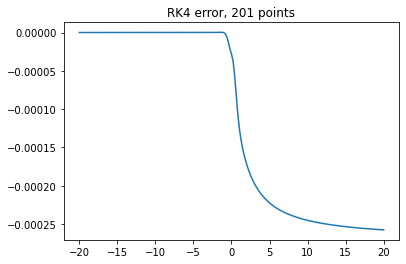

In [7]:
import numpy as np
from matplotlib import pyplot as plt

#solve y'=y/(1+x^2) with RK4


def f(x, y):#y'=y/(1+x^2)
    return y/(1+x**2)


def rk4(fun,x,y,h):
    k1=fun(x,y)*h
    k2=h*fun(x+h/2,y+k1/2)
    k3=h*fun(x+h/2,y+k2/2)
    k4=h*fun(x+h,y+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    return y+dy


npt=201
x=np.linspace(-20,20,npt)
y=np.zeros([2,npt])
y[0,0]=1 #starting conditions

for i in range(npt-1):
    h=x[i+1]-x[i]
    y[:,i+1]=rk4(f,x[i],y[:,i],h)
    

c=1/np.exp(np.arctan(-20))
truth=c*np.exp(np.arctan(x))
print(np.std(truth-y[0,:]))

plt.ion()
plt.plot(x,y[0,:]-truth)
plt.title('RK4 error, ' + repr(npt)+ ' points')
plt.show()

Now we define another solver that takes a step of length $h$, compares that to two steps of length $h / 2$, and uses them to cancel out the leading-order error term from RK4. How many function evaluations per step does this one use? Use this modified stepper to carry out the same ODE solution using the same number of function evaluations as the original. Which is more accurate?


Recalling that for a step-size $h>0$, the Runge Kutta of order 4 method is constructed with:
$$
\begin{aligned}
&y_{n+1}=y_n+\frac{1}{6}\left(k_1+2 k_2+2 k_3+k_4\right) h \\
&x_{n+1}=x_n+h
\end{aligned}
$$
for $n=0,1,2,3, \ldots$ using ${ }^{[3]}$
$$
\begin{aligned}
&k_1=f\left(x_n, y_n\right) \\
&k_2=f\left(x_n+\frac{h}{2}, y_n+h \frac{k_1}{2}\right), \\
&k_3=f\left(x_n+\frac{h}{2}, y_n+h \frac{k_2}{2}\right), \\
&k_4=f\left(x_n+h, y_n+h k_3\right) .
\end{aligned}
$$


With $y_2$ being the approximation obtained using two steps of size $h/2$ and $y_1$ with one step of size $h$,we have:
$$
\begin{aligned}
& {y}_{n+1}=y_1+C h^{ 5}+\mathscr{O}\left(h^{6}\right) \\
& {y}_{n+1}=y_2+2 C\left(\frac{h}{2}\right)^{ 5}+\mathscr{O}\left(h^{6}\right) .
\end{aligned}
$$
So that
$$
\left|y_1-y_2\right|=C h^{ 5}\left(1-\frac{1}{2^4}\right) \Leftrightarrow C=\frac{\left|y_1-y_2\right|}{\left(1-2^{-4}\right) h^{ 5}} .
$$
Substituing the relation  back in the true solution we get
$$
 {y}_{n+1}=y_2+\varepsilon+\mathscr{O}\left(h^{6}\right),
$$
where
$$
\varepsilon=\frac{\left|y_1-y_2\right|}{2^4-1}
$$
can be considered as a convenient indicator of the truncation error. That is, we have improved our estimate to the order $ 5$.
$$
 {y}_{n+1}=y_2+\frac{\left|y_1-y_2\right|}{15}+\mathscr{O}\left(h^6\right) .
$$
This estimate is accurate to fifth order, one order higter than with the original step $h$. However, this method is not efficient. It seems this method, theoretically at least, is more accurate, and it uses 8 function calls (instead of 11 in the classical rk4).

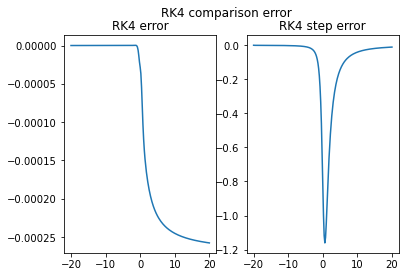

In [21]:
def rk4_stepd(fun, x, y, h):
    #Half step
    k1=fun(x,y)*h
    k2=h*fun(x+h/4,y+k1/4)
    k3=h*fun(x+h/4,y+k2/4)
    k4=h*fun(x+h/2,y+k3/2)
    dy=(k1+2*k2+2*k3+k4)/12
    
    y2=y+2*dy
    y1=rk4(fun,x,y,h)
    
    eps=abs(y2-y1)/15
    
    return y+eps


npt=201
x=np.linspace(-20,20,npt)
y=np.zeros([2,npt])
y_mod=np.zeros([2,npt])

y[0,0]=1#starting conditions
y_mod[0,0]=1

for i in range(npt-1):
    h=x[i+1]-x[i]
    y[:,i+1]=rk4(f,x[i],y[:,i],h)
    y_mod[:,i+1]=rk4_stepd(f,x[i],y[:,i],h)
    
    
    

c=1/np.exp(np.arctan(-20))
truth=c*np.exp(np.arctan(x))
#print(np.std(truth-y[0,:]))

fig, ax = plt.subplots(1, 2)
fig.suptitle('RK4 comparison error')

ax[0].plot(x, y[0,:]-truth)
ax[0].set_title('RK4 error')

ax[1].plot(x,y_mod[0,:]-truth)
ax[1].set_title('RK4 step error')

plt.show()

For some reason, we obtain a bigger error for the improved version. This means that something must have went wrong somewhere. However, I wasn't able to find out what.

The only thing I could think of is how the same step size all over the function could possibly affect the accuracy, since know that if step size is too large, we might shoot off too far in one direction (along the local tangents) and hence potentially miss oscillations or other interesting feature.

Conversely, if the step size is smaller than necessary we might be uselessly increasing -time- complexity and causing a bigger deviation from the true function

# Problem 2

a) Write a program to solve for the decay products of U238 (refer to slides for the decay chain). You can use the ODE solver from scipy, but you'll need to set the problem up properly. Please make sure to include all the decay prodcuts in the chain. Assume you start from a sample of pure U238 (in nature, this sort of separation happens chemically when rocks are formed). Which solver would you use for this problem?

We use a module called radioactivedecay.

The radioactive deacay is modeled by the following equation
$$
-\frac{d N}{d t}=N \lambda
$$
where $\frac{d N}{d t}$ is the number of decays per unit time, $N$ is the current number of radioactive atoms, and $\lambda$ the decay probability.
The analytical solution is straightforward:
$$
N(t)=N(t_0)e^{-\lambda(t-t_0)}
$$
WLOG, we can take $t_0=0$. As for the relation between the decay probability and halflife $\tau_{1/2}$, we use the definition of the latter, ie the time taken for the number atoms to drop by half, to get:
$$
\lambda=\frac{ln(2)}{\tau_{1/2}}
$$

Since the halflifes of elements in the decay chains vary by several orders of magnitudes, we use the method InventoryHP to improve the numerical precision and reduce the round off errors both in computations and display

In [32]:
>>> import radioactivedecay as rd
>>> U238_t0 = rd.InventoryHP({'U-238': 1.0}, 'Bq') #initialize decay chain of 1.0 Bq of U238
>>> U238_t1 = U238_t0.decay(4e9, 'y')
>>> U238_t1.activities('Bq')

{'At-218': 0.0001075381815982559,
 'Bi-210': 0.5376909106645484,
 'Bi-214': 0.5376908004531086,
 'Hg-206': 1.0216127302595074e-08,
 'Pa-234': 0.0008602433606534023,
 'Pa-234m': 0.5376521004082845,
 'Pb-206': 0.0,
 'Pb-210': 0.5376909106628968,
 'Pb-214': 0.5375833698096874,
 'Po-210': 0.5376909107101416,
 'Po-214': 0.537577992923195,
 'Po-218': 0.5376909079912795,
 'Ra-226': 0.537690907990019,
 'Rn-218': 1.0753818159825589e-07,
 'Rn-222': 0.5376909079912787,
 'Th-230': 0.5376907154417977,
 'Th-234': 0.5376521004082843,
 'Tl-206': 7.199681293798004e-07,
 'Tl-210': 0.00011291506809515286,
 'U-234': 0.53768164401697,
 'U-238': 0.5376521004003442}

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time (y)', ylabel='Activity (Bq)'>)

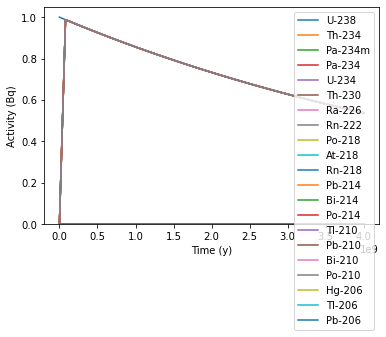

In [30]:
U238_t0.plot(4e9, 'y', yunits='Bq')

# Problem 3

We'll do a linear least-squares fit to some real data in this problem. Look at the file dish_zenith.txt. This contains photogrammetry data for a prototype telescope dish. Photogrammetry attempts to reconstruct surfaces by working out the 3-dimensional positions of targets from many pictures (as an aside, the algorithms behind photogrammetry are another fun least-squarestype problem, but beyond the scope of this class). The end result is that dish_zenith.txt contains the $(\mathrm{x}, \mathrm{y}, \mathrm{z})$ positions in $\mathrm{mm}$ of a few hundred targets placed on the dish. The ideal telescope dish should be a rotationally symmetric paraboloid. We will try to measure the shape of that paraboloid, and see how well we did.

a) Helpfully, I have oriented the points in the file so that the dish is pointing in the $+z$ direction (in the general problem, you would have to fit for direction the dish is pointing in as well, but we will skip that here). For a rotationally symmetric paraboloid, we know that

$$
z-z_{0}=a\left(\left(x-x_{0}\right)^{2}+\left(y-y_{0}\right)^{2}\right)
$$

and we need to solve for $x_{0}, y_{0}, z_{0}$, and $a$. While at first glance this problem may appear non-linear, show that we can pick a new set of parameters that make the problem linear. What are these new parameters, and how do they relate to the old ones?

<IPython.core.display.Javascript object>


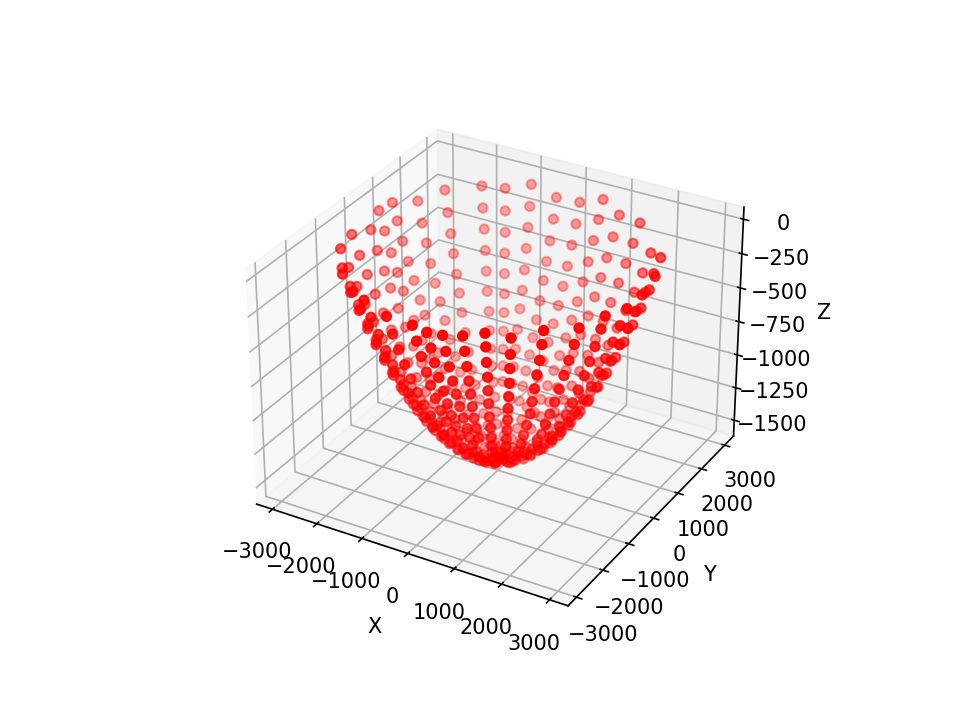

C:\Users\benkh\AppData\Local\Temp\ipykernel_3900\473538444.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [87]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data=np.loadtxt("./dish_zenith.txt")

fig = plt.figure()
ax = fig.gca(projection='3d')
 
x = data[:,0]
y = data[:,1]
z = data[:,2]

ax.scatter(x, y, z, c = 'r')
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")

plt.show()

We see that we can write 
$$
z=f(x,y)
$$
where f has continuous first derivatives. This means that we can approximate curve by its tangents at various points. This is even more useful since we only have a set of point, so all we need is to compute the linear approximation $L(x,y)$ at each of these points.

Even geometrically speaking, we see that we can approximate a paraboloid by a series of tangent planes. See figure below, source openstax.

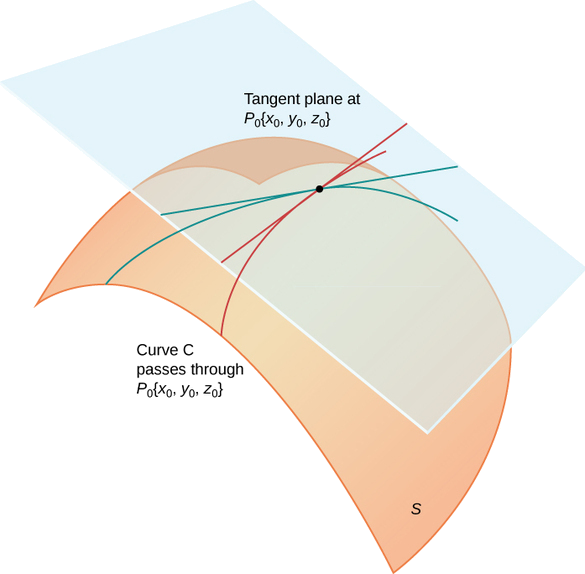

Therefore, one possible way to approximate the surface defined by a differentiable function $z=f(x, y)$, given $P_i=\left(x_i, y_i\right)$ points in the domain of $f$ (ie on the surface) is using the equation of the tangent plane to $S$ at $P_i$:
$$
z\approx L(x,y)_{x_i,y_i}=f\left(x_i, y_i\right)+f_x\left(x_i, y_i\right)\left(x-x_i\right)+f_y\left(x_i, y_i\right)\left(y-y_0\right)
$$

In our case, we have that:
$$
f(x,y)=a\left(\left(x-x_{0}\right)^{2}+\left(y-y_{0}\right)^{2}\right)+z_0
$$

So
$$
f_x(x,y)=2a(x-x_0)
$$

$$
f_y(x,y)=2a(y-y_0)
$$

Hence
$$
z\approx L(x,y)_{x_i,y_i}=z_i+2a(x_i-x_0)\left(x-x_i\right)+2a(y_i-y_0)\left(y-y_0\right)
$$

b) We carry out the fit. What are your best-fit parameters? 

We first try doing a non-linear fit

<IPython.core.display.Javascript object>


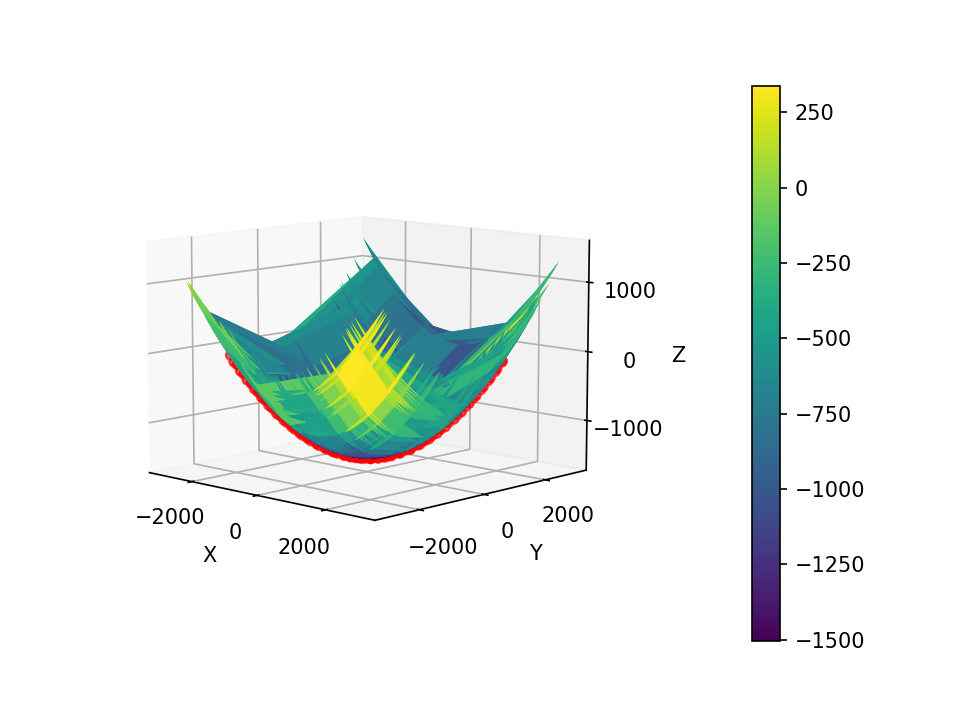

C:\Users\benkh\AppData\Local\Temp\ipykernel_3900\1764995176.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [86]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from mpl_toolkits.mplot3d import Axes3D

matplotlib.use('nbagg')


data=np.loadtxt("./dish_zenith.txt")

fig = plt.figure()
ax = fig.gca(projection='3d')
 
x = data[:,0]
y = data[:,1]
z = data[:,2]

params=[0,0,0,0]

def fun(params, x, y, z):
    a, x0, y0, z0 = params[0], params[1], params[2], params[3]
    residual= z-(a*((x-x0)**2+(y-y0)**2)+z0)
    return residual

    
result = leastsq(fun, params, (x, y, z))

a, x0, y0, z0 = result[0][0], result[0][1], result[0][2], result[0][3]

X, Y = np.meshgrid(x, y)

Z=a*((X-x0)**2+(Y-y0)**2)+z0

surf=ax.plot_surface(X, Y, Z, cmap='viridis')
ax.scatter(x, y, z, c = 'r')
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")

plt.locator_params(axis='z', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)


fig.colorbar(surf, pad=0.2)

plt.show()



Hence, we obtain the following best-fit parameters:

In [76]:
best_fit_parameters=[a, x0, y0, z0]
best_fit_parameters

[0.00016670445476844073,
 -1.3604861614146935,
 58.22147607391623,
 -1512.8772100448714]

We notice some kinds of overshoots at the edges, but that is probably due to the meshing of the curve (since we used meshgrid), as well as the errors at the boundaries of the surface.

Now, we try carrying the fit using the linear approximation derived before

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from mpl_toolkits.mplot3d import Axes3D

matplotlib.use('nbagg')


data=np.loadtxt("./dish_zenith.txt")

fig = plt.figure()
ax = fig.gca(projection='3d')
 
x = data[:,0]
y = data[:,1]
z = data[:,2]

params=[0,0,0,0]

def fun(params, x, y, z):
    a, x0, y0, z0 = params[0], params[1], params[2], params[3]
    residual= z-(a*((x-x0)**2+(y-y0)**2)+z0)
    return residual

    
result = leastsq(fun, params, (x, y, z))

a, x0, y0, z0 = result[0][0], result[0][1], result[0][2], result[0][3]

X, Y = np.meshgrid(x, y)

Z=a*((X-x0)**2+(Y-y0)**2)+z0

surf=ax.plot_surface(X, Y, Z, cmap='viridis')
ax.scatter(x, y, z, c = 'r')
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")

plt.locator_params(axis='z', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)


fig.colorbar(surf, pad=0.2)

plt.show()

